In [10]:
!gdown --id 1DwarYSqBndfGVEo8JQbA_Ekc0oQQnGbk

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DwarYSqBndfGVEo8JQbA_Ekc0oQQnGbk
From (redirected): https://drive.google.com/uc?id=1DwarYSqBndfGVEo8JQbA_Ekc0oQQnGbk&confirm=t&uuid=41dc9135-4043-4991-b070-e3238e9b513f
To: /content/inventory.zip
100% 240M/240M [00:05<00:00, 43.6MB/s]


In [2]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt


## Plotting Predicted Boxes Over The Image

In [4]:
def get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.15):
    image = np.array(img)
    objects = 0

    for i in range(num_detections):
        if scores[i] >= score_threshold:
            box = boxes[i]
            y_min, x_min, y_max, x_max = box

            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            objects += 1

    return image, objects

## Returning the Numpy Array

In [5]:
PATH = r"/content/download (13).png"

def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sample_image_t = tf.constant(img, dtype=tf.uint8)
    sample_image_t = tf.expand_dims(sample_image_t, axis=0)
    image_np = sample_image_t.numpy()
    return image_np

## EffDet Model

In [34]:
IMG_SIZE = [448, 448]

# Paths to the two images
image_paths = r"/content/IMG-20230706-WA0212.png"

test_images = []
test_images_size_tups = []

for img_path in image_paths:
    img = cv2.imread(img_path)
    test_images_size_tups.append(img.shape)

    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    test_images.append(img)


AttributeError: 'NoneType' object has no attribute 'shape'

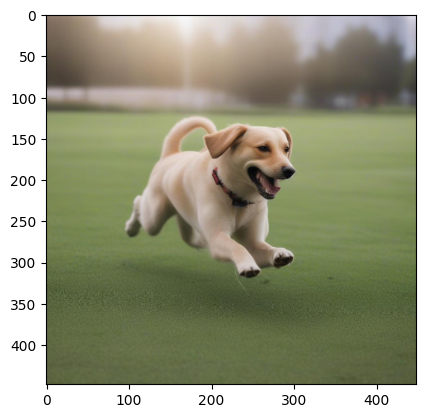

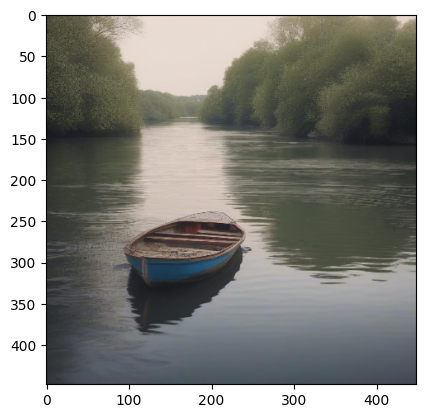

In [12]:
test_images_size_tups[:2], test_images[0].shape, test_images[0].max()

for img in test_images[:2]:
    plt.imshow(img)
    plt.show()

In [13]:
effdet_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite2-detection/versions/1")

In [14]:
def effdet_pred(img, model):
    sample_image_t = tf.constant(img, dtype=tf.uint8)
    sample_image_t = tf.expand_dims(sample_image_t, axis=0)
    image_np = sample_image_t.numpy()

    boxes, scores, classes, num_detections = model(image_np)

    image_np = image_np[0]

    print("Image shape:", image_np.shape)
    print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
    print()

    img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

    print("No. of objects:", objects)
    cv2.imshow("win",img)

In [15]:
index = random.randint(0, len(test_images) - 1)
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

Image index: 0


In [16]:
boxes, scores, classes, num_detections = effdet_model(image_np)

Image shape: (448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)

No. of objects: 1


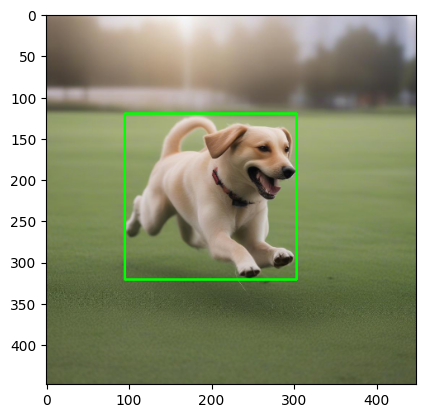

In [17]:
image_np = image_np[0]

print("Image shape:", image_np.shape)
print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
print()

img, objects = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])

print("No. of objects:", objects)
plt.imshow(img)

## Faster RCNN ResNet Model


In [18]:
resnet_model = hub.load("https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/TensorFlow2/640x640/1")

In [19]:
RESNET_IMG_SIZE = [640, 640]

In [30]:
# Custom image
image_path = r"/content/IMG-20230706-WA0212.png"
img = cv2.imread(image_path)
print()
img = cv2.resize(img, RESNET_IMG_SIZE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.constant(img, dtype=tf.uint8)

In [31]:
sample_image_t = tf.constant(img, dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

resnet_output_dict = resnet_model(image_np)

Image shape: (640, 640, 3)
Model Result Shapes: (100, 4) (100,) 100

No. of objects: 3


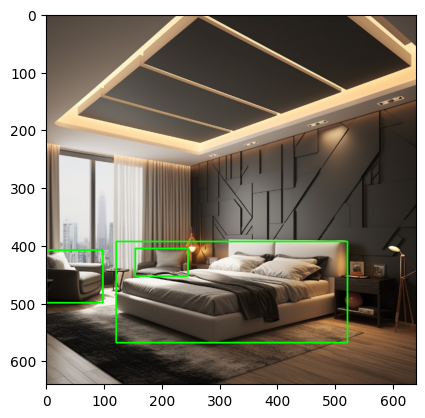

In [32]:
image_np = image_np[0] # removing batch dimension

resnet_boxes = resnet_output_dict.get("detection_boxes")[0] * RESNET_IMG_SIZE[0]
resnet_scores = resnet_output_dict.get("detection_scores")[0]
resnet_num_detections = int(resnet_output_dict.get("num_detections")[0])

print("Image shape:", image_np.shape)
print("Model Result Shapes:", resnet_boxes.shape, resnet_scores.shape, resnet_num_detections)
print()

img, objects = get_annotated_img_objects(image_np, resnet_boxes, resnet_scores, resnet_num_detections, 0.55)

print("No. of objects:", objects)
plt.imshow(img)